In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

# Composition Analysis

The objective of this analysis is to determine whether composition impacts stability (whether compounds with similar composition have similar stability). To do this, I mainly focused on compounds with a single A compound to remove confounding effects from other A site compounds and then do the same for the B site. 
- From the analysis, the conclusion is:
    - It is possible that including composition features may help the performance:
        - We can model the features by:
        1. Use the features of:
            - 'Ba', 'Pr', 'Y', 'La', 'Sr', 'Other' on the A-site
            - 'Fe', 'V', 'Ni', 'Mn', 'Other' on the B-site
        2. Use the features separated by classification and regression (to use less feature variables):
            - Classification:
                - 'La', 'Pr', 'Y', 'Other' on the A-site
                - 'V', 'Other' on the B-site
            - Regression:
                - 'Sr', 'Ba', 'Other' on the A-site
                - 'Ni', 'Fe', 'V', 'Other' on the B-site
        3. For classification, we may even want to include less features that captures interaction effects:
            - Indicator feature for whether A-site includes 'Pr', 'La', 'Y'
            - Another indicator feature for when A-site includes 'Pr' or 'Y' and B-site includes 'V'

    - It is possible that the above features may not help when combined with other numerical features

    - Separately, based on the performance breakdown shown by Jiaying in last meeting, I think it makes sense to stratify train test samples based on major A-site / B-site composition combinations, so that the performance is fairly measured (for ex, if model does particularly well for 'Ba' and test set contains higher proportion of 'Ba' than train, then the evaluation is probably not 'fair'

In [2]:
FILE_PATH = '../../data/stability_paper_data/full_features.xlsx'

In [3]:
composition_df = pd.read_excel(FILE_PATH, sheet_name='DFT Calculated Dataset')
composition_df['y_clf'] = (composition_df['energy_above_hull (meV/atom)'] <= 40).astype(int)

In [4]:
A_SITE_COLUMNS = [
    'A site #1',
    'A site #2',
    'A site #3',
]

B_SITE_COLUMNS = [
    'B site #1',
    'B site #2',
    'B site #3',
]

TARGET_COLUMN = 'energy_above_hull (meV/atom)'

In [5]:
# a1_df are those with single A site
# b1_df are those with single B site

a1_mask = composition_df[A_SITE_COLUMNS].isna().sum(axis=1) == 2
b1_mask = composition_df[B_SITE_COLUMNS].isna().sum(axis=1) == 2

a1_df = composition_df[a1_mask].copy()
b1_df = composition_df[b1_mask].copy()

In [6]:
a1_df['A site #1'].value_counts(normalize=True).round(3).head(10)

Ba    0.220
Pr    0.190
Y     0.190
La    0.189
Sr    0.154
Ca    0.049
Gd    0.001
Nd    0.001
Ho    0.001
Mg    0.001
Name: A site #1, dtype: float64

In [7]:
b1_df['B site #1'].value_counts(normalize=True).round(3).head(10)

Fe    0.196
V     0.122
Mn    0.118
Ni    0.115
Co    0.113
Ga    0.078
Ti    0.078
Cr    0.076
Sc    0.075
Zn    0.003
Name: B site #1, dtype: float64

In [8]:
top_asite_compounds = a1_df['A site #1'].value_counts().head(5).index.values
sub_df_a = a1_df[a1_df['A site #1'].isin(top_asite_compounds)]

top_bsite_compounds = b1_df['B site #1'].value_counts().head(5).index.values
sub_df_b = b1_df[b1_df['B site #1'].isin(top_bsite_compounds)]

In [9]:
print('Top A Site compounds for study:', top_asite_compounds)
print('Top B Site compounds for study:', top_bsite_compounds)

Top A Site compounds for study: ['Ba' 'Pr' 'Y' 'La' 'Sr']
Top B Site compounds for study: ['Fe' 'V' 'Mn' 'Ni' 'Co']


## 1. Conclusion from Stats
- A site compounds with La, Pr, Y, are more likely to have stable behavior than Ba, Sr 
- B site compounds with V are more likely to have stable behavior than others
- B site compounds with Ni, Fe tend to have particularly unstable behavior
- Judging from the F-stat p-value at 5% significance (to see if each compound is a significant separator among those that contain the compound and those that don't contain), I would separate those as:
    - 'Ba', 'Pr', 'Y', 'La', 'Sr', 'Other' on the A-site
    - 'Fe', 'V', 'Ni', 'Mn', 'Other' on the B-site

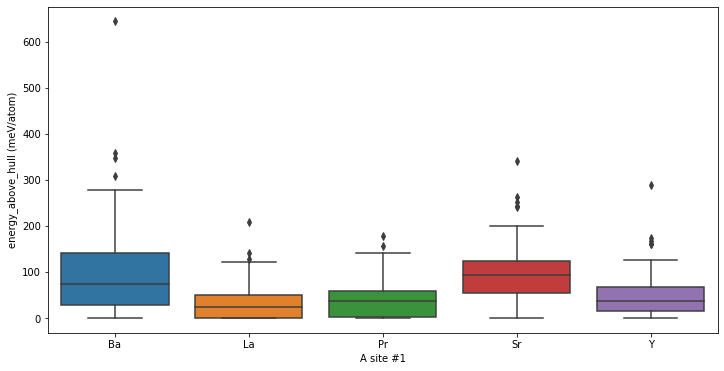

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=sub_df_a, 
            x='A site #1', 
            y='energy_above_hull (meV/atom)',
            ax=ax)

plt.show()

In [11]:
sub_df_a.groupby('A site #1')[TARGET_COLUMN].agg(['mean', 'std']).round(1)

,mean,std
A site #1,,
Ba,97.1,90.9
La,32.5,39.8
Pr,41.3,38.6
Sr,95.9,63.6
Y,46.1,43.8


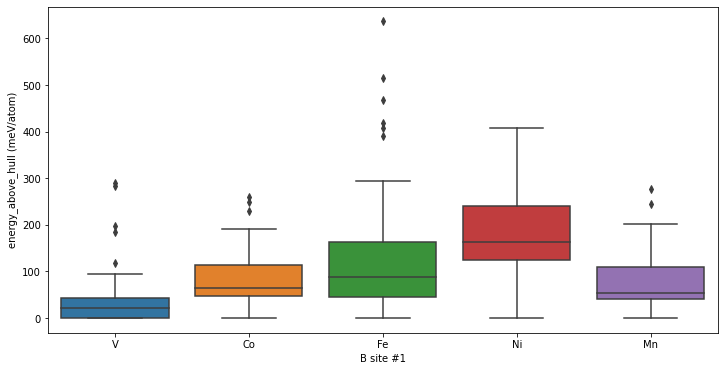

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=sub_df_b, 
            x='B site #1', 
            y='energy_above_hull (meV/atom)',
            ax=ax)

plt.show()

In [13]:
sub_df_b.groupby('B site #1')[TARGET_COLUMN].agg(['mean', 'std']).round(1)

,mean,std
B site #1,,
Co,82.4,57.6
Fe,117.8,112.2
Mn,75.0,55.0
Ni,178.2,97.7
V,34.8,53.9


In [14]:
f_stat_result = []

for compound in top_asite_compounds:
    group1 = sub_df_a[sub_df_a['A site #1'] == compound][TARGET_COLUMN].values
    group2 = sub_df_a[sub_df_a['A site #1'] != compound][TARGET_COLUMN].values
    
    anova_result = stats.f_oneway(group1, group2)
    
    f_stat_result.append({'compound': compound, 'pval': anova_result.pvalue})
    
f_stat_df = pd.DataFrame(f_stat_result).sort_values('pval')

In [15]:
f_stat_df.round(8)

,compound,pval
0,Ba,0.000000
3,La,0.000000
4,Sr,0.000000
1,Pr,0.000014
2,Y,0.000797


In [16]:
f_stat_result = []

for compound in top_bsite_compounds:
    group1 = sub_df_b[sub_df_b['B site #1'] == compound][TARGET_COLUMN].values
    group2 = sub_df_b[sub_df_b['B site #1'] != compound][TARGET_COLUMN].values
    
    anova_result = stats.f_oneway(group1, group2)
    
    f_stat_result.append({'compound': compound, 'pval': anova_result.pvalue})
    
f_stat_df = pd.DataFrame(f_stat_result).sort_values('pval')

In [17]:
f_stat_df.round(8)

,compound,pval
3,Ni,0.000000
1,V,0.000000
0,Fe,0.007650
2,Mn,0.011544
4,Co,0.086440


## 2. Decision Trees to See Which Features Give the Greatest Separation in Predicting the Target
- Features that give better classification are different for Regression vs. Classification
    - Classification
        - 'La', 'Pr', 'Y' are particularly important features from A site to determine whether stable or not
        - 'V', 'Other' are particularly important features from B site to determine whether stable or not
    - Regression
        - 'Other', 'Sr', 'Ba' are particularly important features from A site for regression
        - 'Ni', 'Fe', 'V' are particularly important features from B site for regression

In [18]:
from sklearn.tree import (
    DecisionTreeRegressor, DecisionTreeClassifier,
    plot_tree
)

In [19]:
A_SITE_COMPOUND_MAP = {
    'Ba': 'Ba', 
    'Pr': 'Pr', 
    'Y': 'Y', 
    'La': 'La', 
    'Sr': 'Sr', 
}

B_SITE_COMPOUND_MAP = {
    'Fe': 'Fe', 
    'V': 'V', 
    'Ni': 'Ni', 
    'Mn': 'Mn',
}

In [20]:
def get_feature_importance(model, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names,
                                  'importance': model.feature_importances_,}).sort_values(
        'importance', ascending=False).round(2)
    return importance_df

In [21]:
a1_df_copy = a1_df.copy()
a1_df_copy['A site #1'] = a1_df_copy['A site #1'].map(A_SITE_COMPOUND_MAP).fillna('Other')
a1_X = a1_df_copy['A site #1']
a1_y = a1_df_copy[TARGET_COLUMN]
a1_y_clf = a1_df_copy['y_clf']
a1_X = pd.get_dummies(a1_X, drop_first=False)

In [22]:
b1_df_copy = b1_df.copy()
b1_df_copy['B site #1'] = b1_df_copy['B site #1'].map(B_SITE_COMPOUND_MAP).fillna('Other')
b1_X = b1_df_copy['B site #1']
b1_y = b1_df_copy[TARGET_COLUMN]
b1_y_clf = b1_df_copy['y_clf']
b1_X = pd.get_dummies(b1_X, drop_first=False)

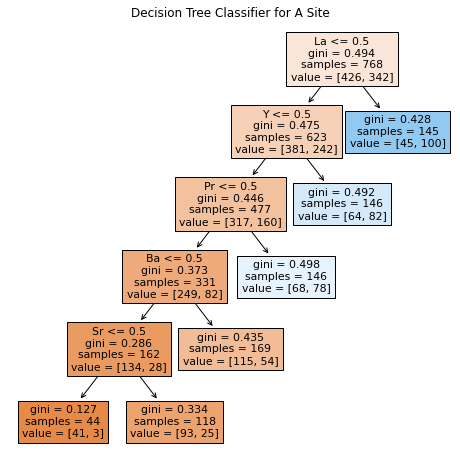

In [23]:
clf = DecisionTreeClassifier(max_depth=5,
                             min_samples_split=5,
                             min_samples_leaf=5)

clf.fit(a1_X, a1_y_clf)

fig, ax = plt.subplots(figsize=(8, 8))

plot_tree(clf, 
          filled=True, 
          feature_names=a1_X.columns,
          ax=ax)
plt.title('Decision Tree Classifier for A Site')
plt.show()

In [24]:
get_feature_importance(clf, a1_X.columns)

,feature,importance
1,La,0.39
3,Pr,0.31
5,Y,0.21
0,Ba,0.07
4,Sr,0.02
2,Other,0.00


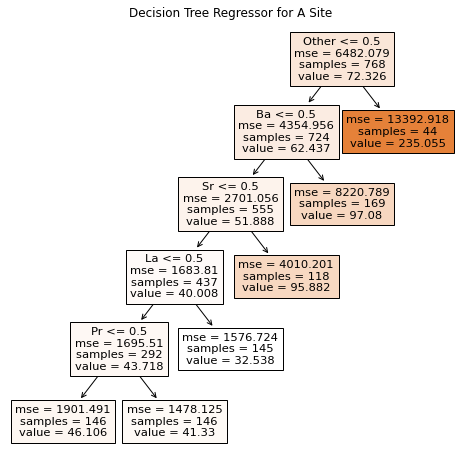

In [25]:
reg = DecisionTreeRegressor(max_depth=5,
                            min_samples_split=5,
                            min_samples_leaf=5)

reg.fit(a1_X, a1_y)

fig, ax = plt.subplots(figsize=(8, 8))

plot_tree(reg, 
          filled=True, 
          feature_names=a1_X.columns,
          ax=ax)
plt.title('Decision Tree Regressor for A Site')
plt.show()

In [26]:
get_feature_importance(reg, a1_X.columns)

,feature,importance
2,Other,0.68
4,Sr,0.16
0,Ba,0.15
1,La,0.01
3,Pr,0.00
5,Y,0.00


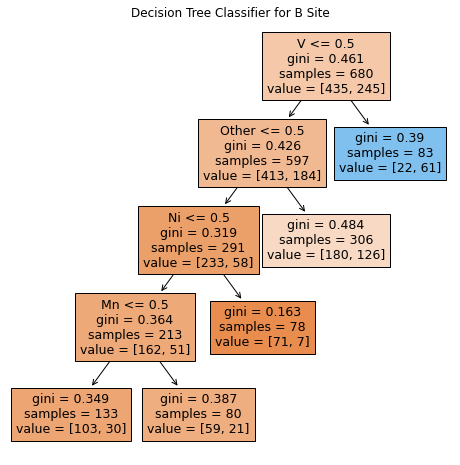

In [27]:
clf = DecisionTreeClassifier(max_depth=5,
                             min_samples_split=5,
                             min_samples_leaf=5)

clf.fit(b1_X, b1_y_clf)

fig, ax = plt.subplots(figsize=(8, 8))

plot_tree(clf, 
          filled=True, 
          feature_names=b1_X.columns,
          ax=ax)
plt.title('Decision Tree Classifier for B Site')
plt.show()

In [28]:
get_feature_importance(clf, b1_X.columns)

,feature,importance
4,V,0.62
3,Other,0.32
2,Ni,0.06
1,Mn,0.00
0,Fe,0.00


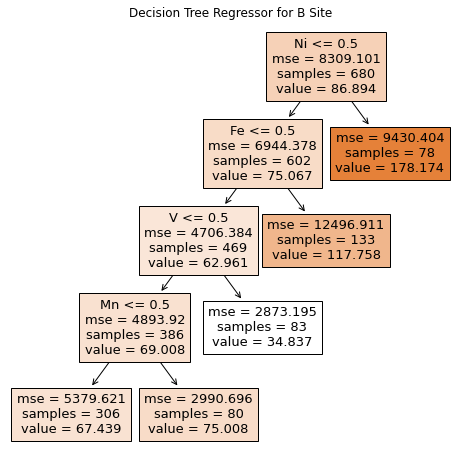

In [29]:
reg = DecisionTreeRegressor(max_depth=5,
                            min_samples_split=5,
                            min_samples_leaf=5)

reg.fit(b1_X, b1_y)

fig, ax = plt.subplots(figsize=(8, 8))

plot_tree(reg, 
          filled=True, 
          feature_names=b1_X.columns,
          ax=ax)
plt.title('Decision Tree Regressor for B Site')
plt.show()

In [30]:
get_feature_importance(reg, b1_X.columns)

,feature,importance
2,Ni,0.65
0,Fe,0.28
4,V,0.07
1,Mn,0.00
3,Other,0.00


## 3. Interaction Effects Between Major A site & B site Compounds
- From the box plot, we can see that:
    - When A site doesn't include the compounds 'Pr', 'La', 'Y' then it is likely to be unstable
    - When A site includes the compounds 'Pr' or 'Y' and B site includes the compound 'V' then it is likely to be stable

In [31]:
A_CLF_COMPOUNDS = ['La', 'Pr', 'Y']
B_CLF_COMPOUNDS = ['V']

In [32]:
def get_compound_feature(row, 
                         compound_cols=['A site #1', 'A site #2', 'A site #3'],
                         ref_compounds=A_CLF_COMPOUNDS):
    
    included_compounds = []
    
    for col in compound_cols:
        included_compounds.append(row[col])
        
    features = list(set(included_compounds) & set(ref_compounds))
    
    if not len(features):
        return 'Other'
    else:
        return features[0]

In [33]:
composition_df['asite_feature'] = composition_df.apply(lambda r: 
                                                       get_compound_feature(r,
                                                                            compound_cols=['A site #1', 'A site #2', 'A site #3'],
                                                                            ref_compounds=A_CLF_COMPOUNDS),
                                                        axis=1)
composition_df['bsite_feature'] = composition_df.apply(lambda r: 
                                                       get_compound_feature(r,
                                                                            compound_cols=['B site #1', 'B site #2', 'B site #3'],
                                                                            ref_compounds=B_CLF_COMPOUNDS),
                                                       axis=1)

In [34]:
composition_df['asite_feature'].value_counts()

Other    685
Pr       436
La       422
Y        386
Name: asite_feature, dtype: int64

In [35]:
composition_df['bsite_feature'].value_counts()

Other    1708
V         221
Name: bsite_feature, dtype: int64

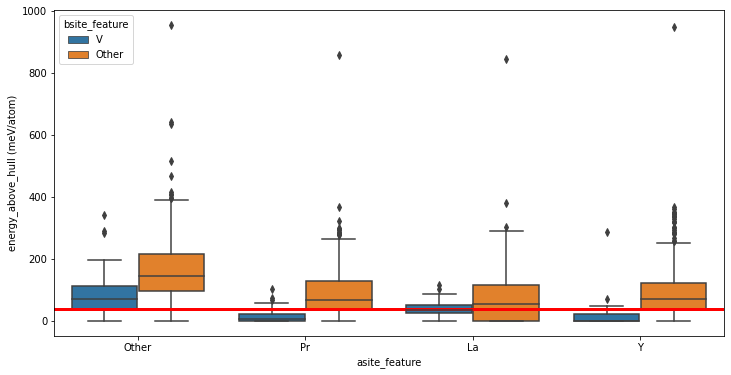

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=composition_df, 
            x='asite_feature', 
            hue='bsite_feature',
            y='energy_above_hull (meV/atom)',
            ax=ax)

ax.axhline(y=40, c='r', linewidth=3)

plt.show()